# Temporal consistency of preterm dysmaturation - macroscale
## Extent and location of IBAPs
Despite tremendous heterogeneity in brain aberrations after preterm birth, we found some commonalities between subjects. Therefore, we show in this notebook that:
1. The extent of the IBAPs (i.e., number of extranormal regions within a subject) scales with gestational age
2. The locations of the IBAPs are consistent along individual development

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np

from statsmodels.stats.multitest import fdrcorrection

import gc

# plot settings
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

# import custom functions
import sys
sys.path.append('code')
from plotting import correlation_plot, plot_percentage_outside_norm_groups
from analysis_helpers import get_roi_names
from longitudinal import *

# directories
centile_dir = 'outputs/spatial_heterogeneity'
outputs_dir = 'outputs/consistency_macroscale'
os.makedirs(outputs_dir, exist_ok=True)


color_pt = 'darkorange'

In [3]:
# load all necessary data, i.e., deviation scores computed in script 1
try:
    # Q1: extent of IBAPs
    bls_26_ct = pd.read_csv(join(centile_dir, 'BLS-26/IBAP_CT/BLS-26_CT_centiles_per_subject.csv'), index_col=0)
    dhcp_ct = pd.read_csv(join(centile_dir, 'dHCP/IBAP_CT/dHCP_CT_centiles_per_subject.csv'), index_col=0)
    
    # Q2: locations of IBAPs
    bls_26_sa = pd.read_csv(join(centile_dir, 'BLS-26/IBAP_SA/BLS-26_SA_centiles_per_subject.csv'))
    bls_26_sa = bls_26_sa.set_index(['participant', 'session'])
    
    bls_38_sa = pd.read_csv(join(centile_dir, 'BLS-38/IBAP_SA/BLS-38_SA_centiles_per_subject.csv'))
    bls_38_sa['session'] = 2
    bls_38_sa = bls_38_sa.set_index(['participant', 'session'])
    
    abcd_sa = pd.read_csv(join(centile_dir, 'ABCD-10/IBAP_SA/ABCD-10_SA_centiles_per_subject.csv'))  # contains both sessions
    abcd_sa = abcd_sa.set_index(['participant', 'session'])
    
except FileNotFoundError:
    print('Run script 1 for all required modalities and datasets first: BLS-26 CT, BLS-26 SA, BLS-38 SA, dHCP CT, ABCD-10 SA')
    sys.exit()

# 1. The extent of the IBAPs scales with gestational age

### Number of extranormal regions is correlated with gestational age

In [4]:
out_dir = join(outputs_dir, 'extent')
os.makedirs(out_dir, exist_ok=True)

# restore plot settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

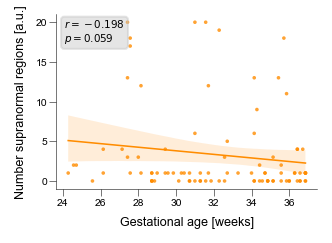

In [5]:
# dHCP CT
x = 'GA'
y = 'amount_supranormal'
outname = join(out_dir, f'dHCP_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
dhcp_ct_pt = dhcp_ct[dhcp_ct['dx'] == 'preterm']

correlation_plot(x, y, data=dhcp_ct_pt, color=color_pt, 
                xlabel='Gestational age [weeks]', ylabel='Number supranormal regions [a.u.]', outname=outname)

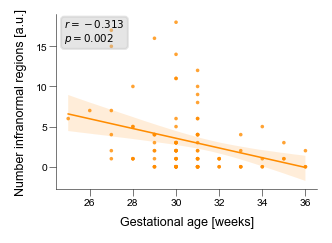

In [6]:
# BLS-26 CT
x = 'GA'
y = 'amount_infranormal'
outname = join(out_dir, f'BLS-26_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
bls_26_ct_pt = bls_26_ct[bls_26_ct['dx'] == 'preterm']

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel='Gestational age [weeks]', ylabel='Number infranormal regions [a.u.]', outname=outname)

In [7]:
# FDR correction
_, p_fdr = fdrcorrection(pvals=[0.059, 0.002], alpha=0.05, method='indep')
print(f'FDR-corrected p-values: {p_fdr}')

FDR-corrected p-values: [0.059 0.004]


### Number of extranormal deviations scales with gestational age

In [8]:
# get roi names
rois_cortical = get_roi_names('CT', bilateral=True, global_vars=False)

--- dHCP CT ---
Born before 28 weeks: n = 14
Born between 28 and 32 weeks: n = 30
Born between 32 and 37 weeks: n = 48


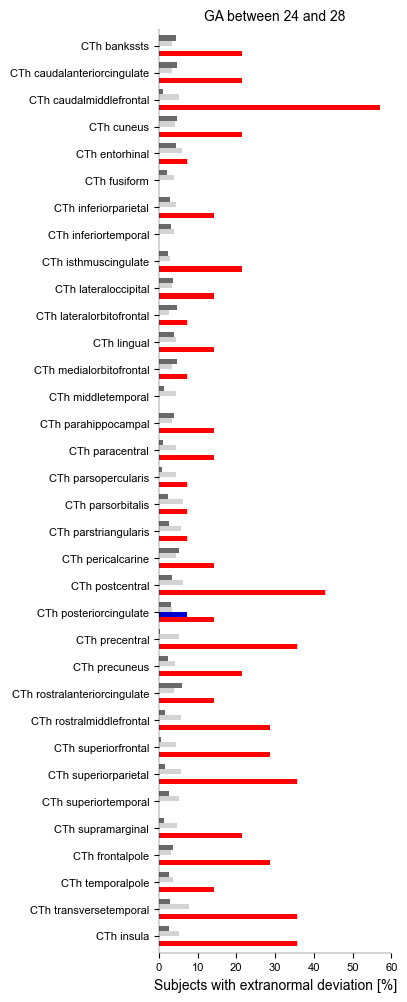

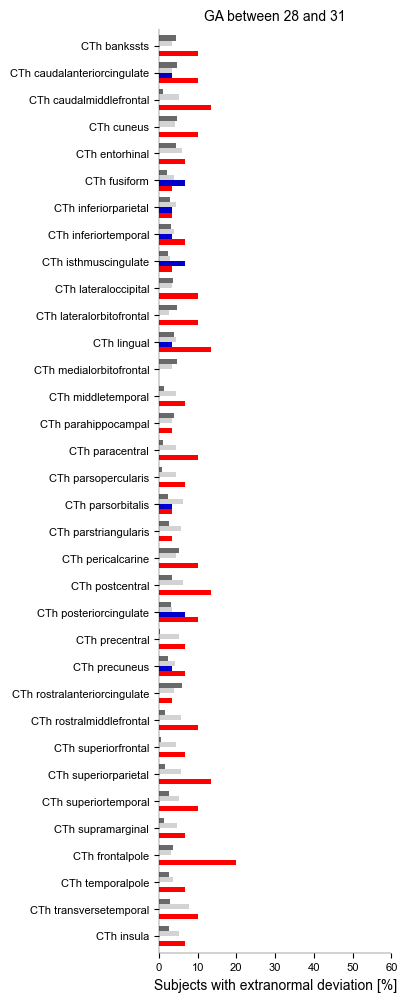

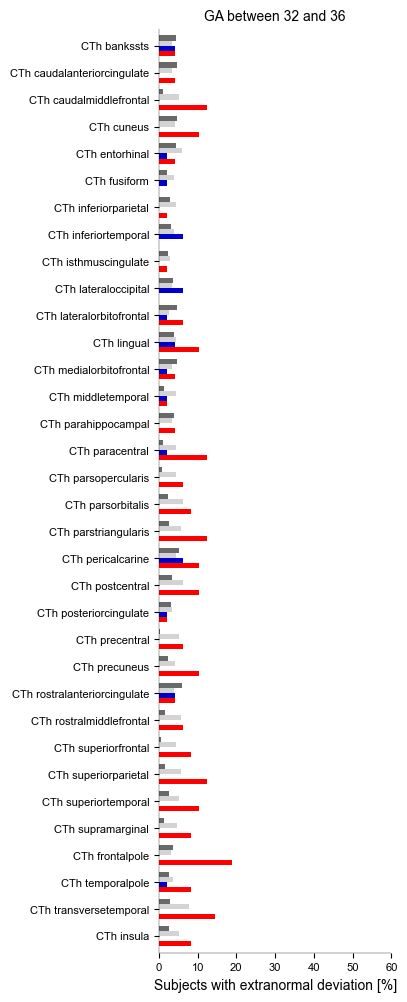

Up to 57% of preterm subjects born before 28 weeks gestational age share a supranormal region in the same location
Up to 20% of preterm subjects born between 28 and 32 weeks gestational age share a supranormal region in the same location
Up to 19% of preterm subjects born after 32 weeks gestational age share a supranormal region in the same location


In [9]:
# group dHCP preterm subjects into earlier and later birth
print('--- dHCP CT ---')
cent_scores_pt_before28 = dhcp_ct_pt[(dhcp_ct_pt['GA'] <= 28)]
print("Born before 28 weeks: n =", cent_scores_pt_before28.shape[0])

cent_scores_pt_28_to_32 = dhcp_ct_pt[(dhcp_ct_pt['GA'] > 28) & (dhcp_ct_pt['GA'] <= 32)]
print("Born between 28 and 32 weeks: n =", cent_scores_pt_28_to_32.shape[0])

cent_scores_pt_after32 = dhcp_ct_pt[(dhcp_ct_pt['GA'] > 32) & (dhcp_ct_pt['GA'] < 37)]
print("Born between 32 and 37 weeks: n =", cent_scores_pt_after32.shape[0])

dhcp_ct_ft = dhcp_ct[dhcp_ct['dx'] == 'CN']


# before 28 weeks
age_thr_lower = int(cent_scores_pt_before28['GA'].min())
age_thr_upper = int(cent_scores_pt_before28['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_before28 = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_before28, age_thr_lower, age_thr_upper, outname)

# between 28 and 32 weeks
age_thr_lower = int(cent_scores_pt_28_to_32['GA'].min())
age_thr_upper = int(cent_scores_pt_28_to_32['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_between28_and_32 = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_28_to_32, age_thr_lower, age_thr_upper, outname)

# after 32 weeks
age_thr_lower = int(cent_scores_pt_after32['GA'].min())
age_thr_upper = int(cent_scores_pt_after32['GA'].max())
outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_after_32 = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_after32, age_thr_lower, age_thr_upper, outname)


# extranormal percentages
print(f'Up to {infra_supra_before28.supranormal_pt.max():.0f}% of preterm subjects born before 28 weeks gestational age share a supranormal region in the same location')
print(f'Up to {infra_supra_between28_and_32.supranormal_pt.max():.0f}% of preterm subjects born between 28 and 32 weeks gestational age share a supranormal region in the same location')
print(f'Up to {infra_supra_after_32.supranormal_pt.max():.0f}% of preterm subjects born after 32 weeks gestational age share a supranormal region in the same location')

In [10]:
# # group dHCP preterm subjects into earlier and later birth
# print('--- dHCP CT ---')
# cent_scores_pt_before30 = dhcp_ct_pt[(dhcp_ct_pt['GA'] <= 30)]
# print("Born before 30 weeks: n =", cent_scores_pt_before30.shape[0])

# cent_scores_pt_after30 = dhcp_ct_pt[(dhcp_ct_pt['GA'] > 30) & (dhcp_ct_pt['GA'] < 37)]
# print("Born between 30 and 36 weeks: n =", cent_scores_pt_after30.shape[0])

# dhcp_ct_ft = dhcp_ct[dhcp_ct['dx'] == 'CN']


# # before 30 weeks
# age_thr_lower = int(cent_scores_pt_before30['GA'].min())
# age_thr_upper = int(cent_scores_pt_before30['GA'].max())
# outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
# infra_supra_before = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_before30, age_thr_lower, age_thr_upper, outname)

# # after 30 weeks
# age_thr_lower = int(cent_scores_pt_after30['GA'].min())
# age_thr_upper = int(cent_scores_pt_after30['GA'].max())
# outname = join(out_dir, f'dHCP_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
# infra_supra_after = plot_percentage_outside_norm_groups(rois_cortical, dhcp_ct_ft, cent_scores_pt_after30, age_thr_lower, age_thr_upper, outname)


# # extranormal percentages
# print(f'Up to {infra_supra_before.supranormal_pt.max():.0f}% of preterm subjects born before 30 weeks gestational age share a supranormal region in the same location')
# print(f'Up to {infra_supra_after.supranormal_pt.max():.0f}% of preterm subjects born after 30 weeks gestational age share a supranormal region in the same location')

--- BLS-26 CT ---
Born before 28 weeks: n = 14
Born between 28 and 32 weeks: n = 67
Born between 32 and 37 weeks: n = 15


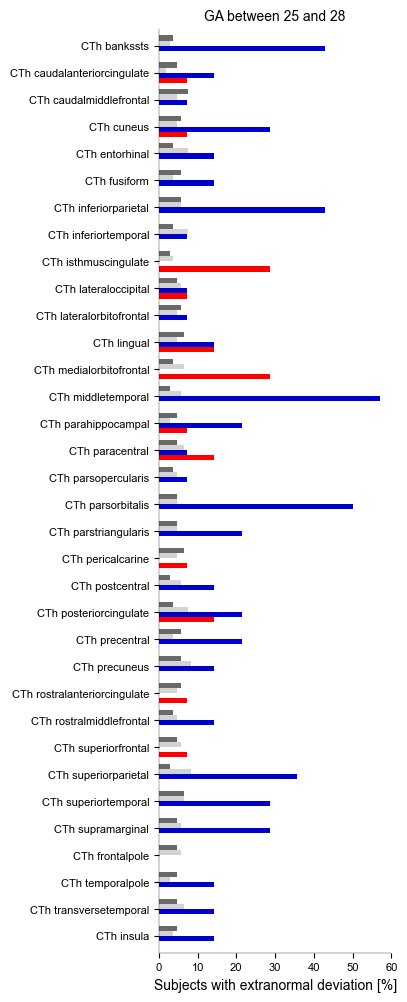

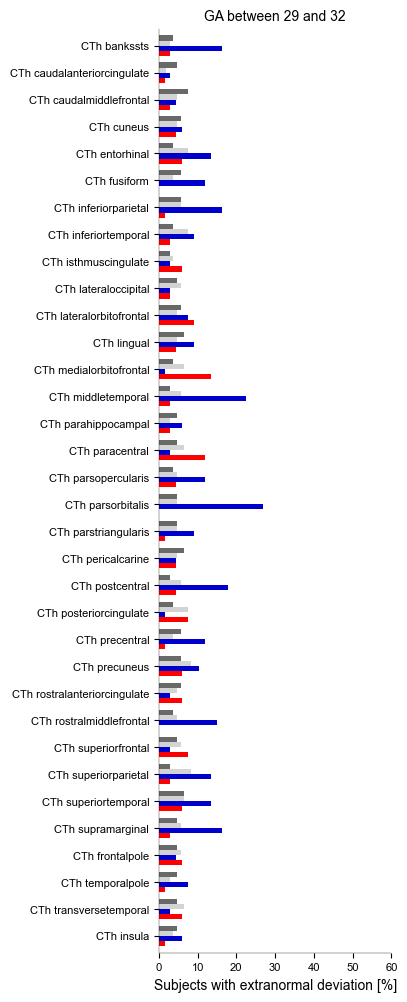

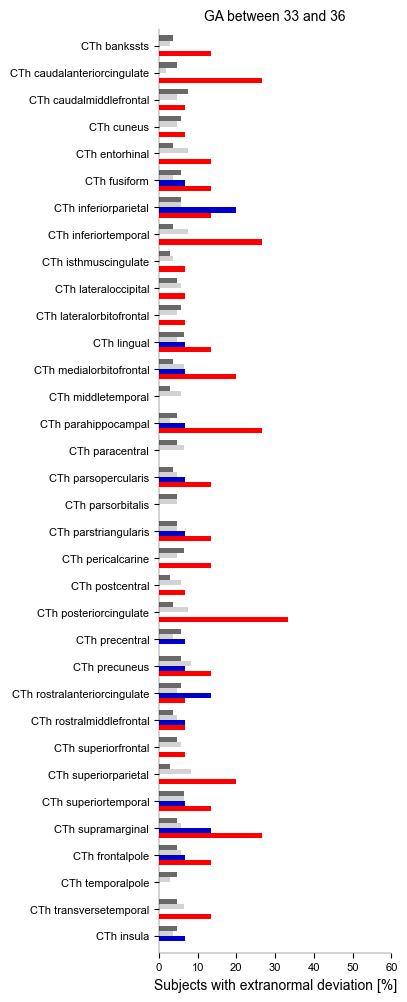

Up to 57% of preterm subjects born before 28 weeks gestational age share an infranormal region in the same location
Up to 27% of preterm subjects born between 28 and 32 weeks gestational age share an infranormal region in the same location
Up to 20% of preterm subjects born after 32 weeks gestational age share an infranormal region in the same location


In [11]:
# group BLS-26 preterm subjects into earlier and later birth
print('--- BLS-26 CT ---')
cent_scores_pt_before28 = bls_26_ct_pt[(bls_26_ct_pt['GA'] <= 28)]
print("Born before 28 weeks: n =", cent_scores_pt_before28.shape[0])

cent_scores_pt_28_to_32 = bls_26_ct_pt[(bls_26_ct_pt['GA'] > 28) & (bls_26_ct_pt['GA'] <= 32)]
print("Born between 28 and 32 weeks: n =", cent_scores_pt_28_to_32.shape[0])

cent_scores_pt_after32 = bls_26_ct_pt[(bls_26_ct_pt['GA'] > 32) & (bls_26_ct_pt['GA'] < 37)]
print("Born between 32 and 37 weeks: n =", cent_scores_pt_after32.shape[0])

bls_26_ct_ft = bls_26_ct[bls_26_ct['dx'] == 'CN']


# before 28 weeks
age_thr_lower = int(cent_scores_pt_before28['GA'].min())
age_thr_upper = int(cent_scores_pt_before28['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_before28 = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_before28, age_thr_lower, age_thr_upper, outname)

# between 28 and 32 weeks
age_thr_lower = int(cent_scores_pt_28_to_32['GA'].min())
age_thr_upper = int(cent_scores_pt_28_to_32['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_between28_and_32 = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_28_to_32, age_thr_lower, age_thr_upper, outname)

# after 32 weeks
age_thr_lower = int(cent_scores_pt_after32['GA'].min())
age_thr_upper = int(cent_scores_pt_after32['GA'].max())
outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
infra_supra_after_32 = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_after32, age_thr_lower, age_thr_upper, outname)

# extranormal percentages
print(f'Up to {infra_supra_before28.infranormal_pt.max():.0f}% of preterm subjects born before 28 weeks gestational age share an infranormal region in the same location')
print(f'Up to {infra_supra_between28_and_32.infranormal_pt.max():.0f}% of preterm subjects born between 28 and 32 weeks gestational age share an infranormal region in the same location')
print(f'Up to {infra_supra_after_32.infranormal_pt.max():.0f}% of preterm subjects born after 32 weeks gestational age share an infranormal region in the same location')

In [12]:
# # group BLS-26 preterm subjects into earlier and later birth
# print('--- BLS-26 CT ---')
# cent_scores_pt_before30 = bls_26_ct_pt[(bls_26_ct_pt['GA'] <= 30)]
# print("Born before 30 weeks:", cent_scores_pt_before30.shape[0])

# cent_scores_pt_after30 = bls_26_ct_pt[(bls_26_ct_pt['GA'] > 30) & (bls_26_ct_pt['GA'] < 37)]
# print("Born between 30 and 36 weeks:", cent_scores_pt_after30.shape[0])

# bls_26_ct_ft = bls_26_ct[bls_26_ct['dx'] == 'CN']


# # before 30 weeks
# age_thr_lower = int(cent_scores_pt_before30['GA'].min())
# age_thr_upper = int(cent_scores_pt_before30['GA'].max())
# outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
# infra_supra_before = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_before30, age_thr_lower, age_thr_upper, outname)

# # after 30 weeks
# age_thr_lower = int(cent_scores_pt_after30['GA'].min())
# age_thr_upper = int(cent_scores_pt_after30['GA'].max())
# outname = join(out_dir, f'BLS-26_individual_percentage_outside_norm_GA{age_thr_lower}_{age_thr_upper}.svg')
# infra_supra_after = plot_percentage_outside_norm_groups(rois_cortical, bls_26_ct_ft, cent_scores_pt_after30, age_thr_lower, age_thr_upper, outname, add_legend=True)

# # extranormal percentages
# print(f'Up to {infra_supra_before.infranormal_pt.max():.0f}% of preterm subjects born before 30 weeks gestational age share an infranormal region in the same location')
# print(f'Up to {infra_supra_after.infranormal_pt.max():.0f}% of preterm subjects born after 30 weeks gestational age share an infranormal region in the same location')

## Control analysis: association of amount of infranormal regions with severity of prematurity

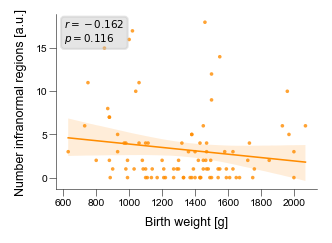

In [13]:
# BLS-26 CT - BW
x = 'BW'
y = 'amount_infranormal'
outname = join(out_dir, f'BLS-26_CT_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel='Birth weight [g]', ylabel='Number infranormal regions [a.u.]', outname=outname)

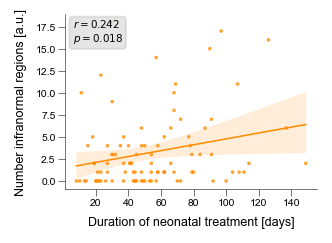

In [14]:
# BLS-26 CT - DNTI
x = 'dnti'
y = 'amount_infranormal'
outname = join(out_dir, f'BLS-26_CT_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel='Duration of neonatal treatment [days]', ylabel='Number infranormal regions [a.u.]', outname=outname)

In [16]:
# FDR correction
_, p_fdr = fdrcorrection(pvals=[0.116, 0.018], alpha=0.05, method='indep')
print(f'FDR-corrected p-values: {p_fdr}')

FDR-corrected p-values: [0.116 0.036]


In [20]:
gc.collect()

63290

# 2. The locations of the IBAPs are consistent along individual development

In [21]:
out_dir = join(outputs_dir, 'location')
os.makedirs(out_dir, exist_ok=True)

rois_cortical = get_roi_names('SA', bilateral=True, global_vars=False)
rois_cortical_centiles = ['centile_' + roi for roi in rois_cortical]

## Child development - ABCD

/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_84266/2886944705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcd_sa_pt.rename(columns={'session': 'timepoint'}, inplace=True)


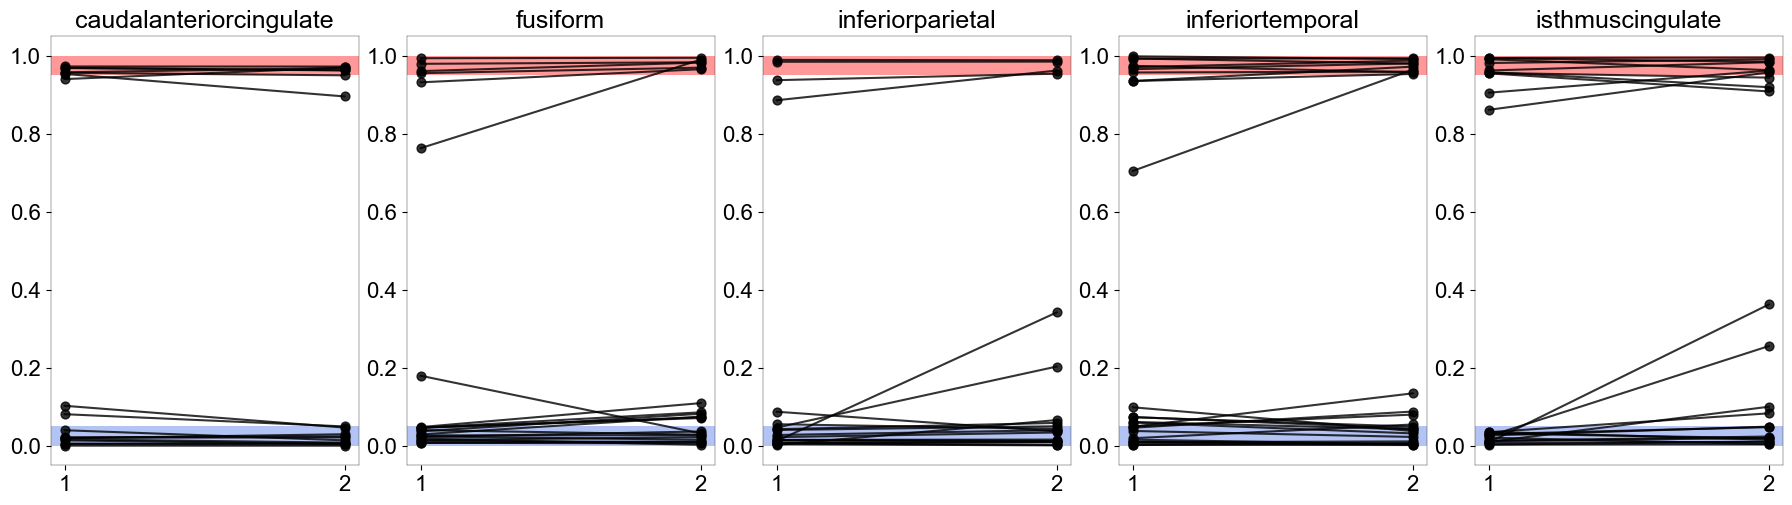

In [22]:
# filter for preterm
abcd_sa_pt = abcd_sa[abcd_sa['dx'] == 'preterm']
abcd_sa_pt.reset_index(inplace=True)
abcd_sa_pt.rename(columns={'session': 'timepoint'}, inplace=True)


# show a reduced amount of rois in the main part
rois_main = ['centile_SA_caudalanteriorcingulate', 'centile_SA_fusiform', 'centile_SA_inferiorparietal', 
                'centile_SA_inferiortemporal', 'centile_SA_isthmuscingulate']
plot_longitudinal_data_subplots(abcd_sa_pt, rois_main, 'SA', out_dir, filter_extranormal=True, num_plots=len(rois_main),dataset='ABCD')

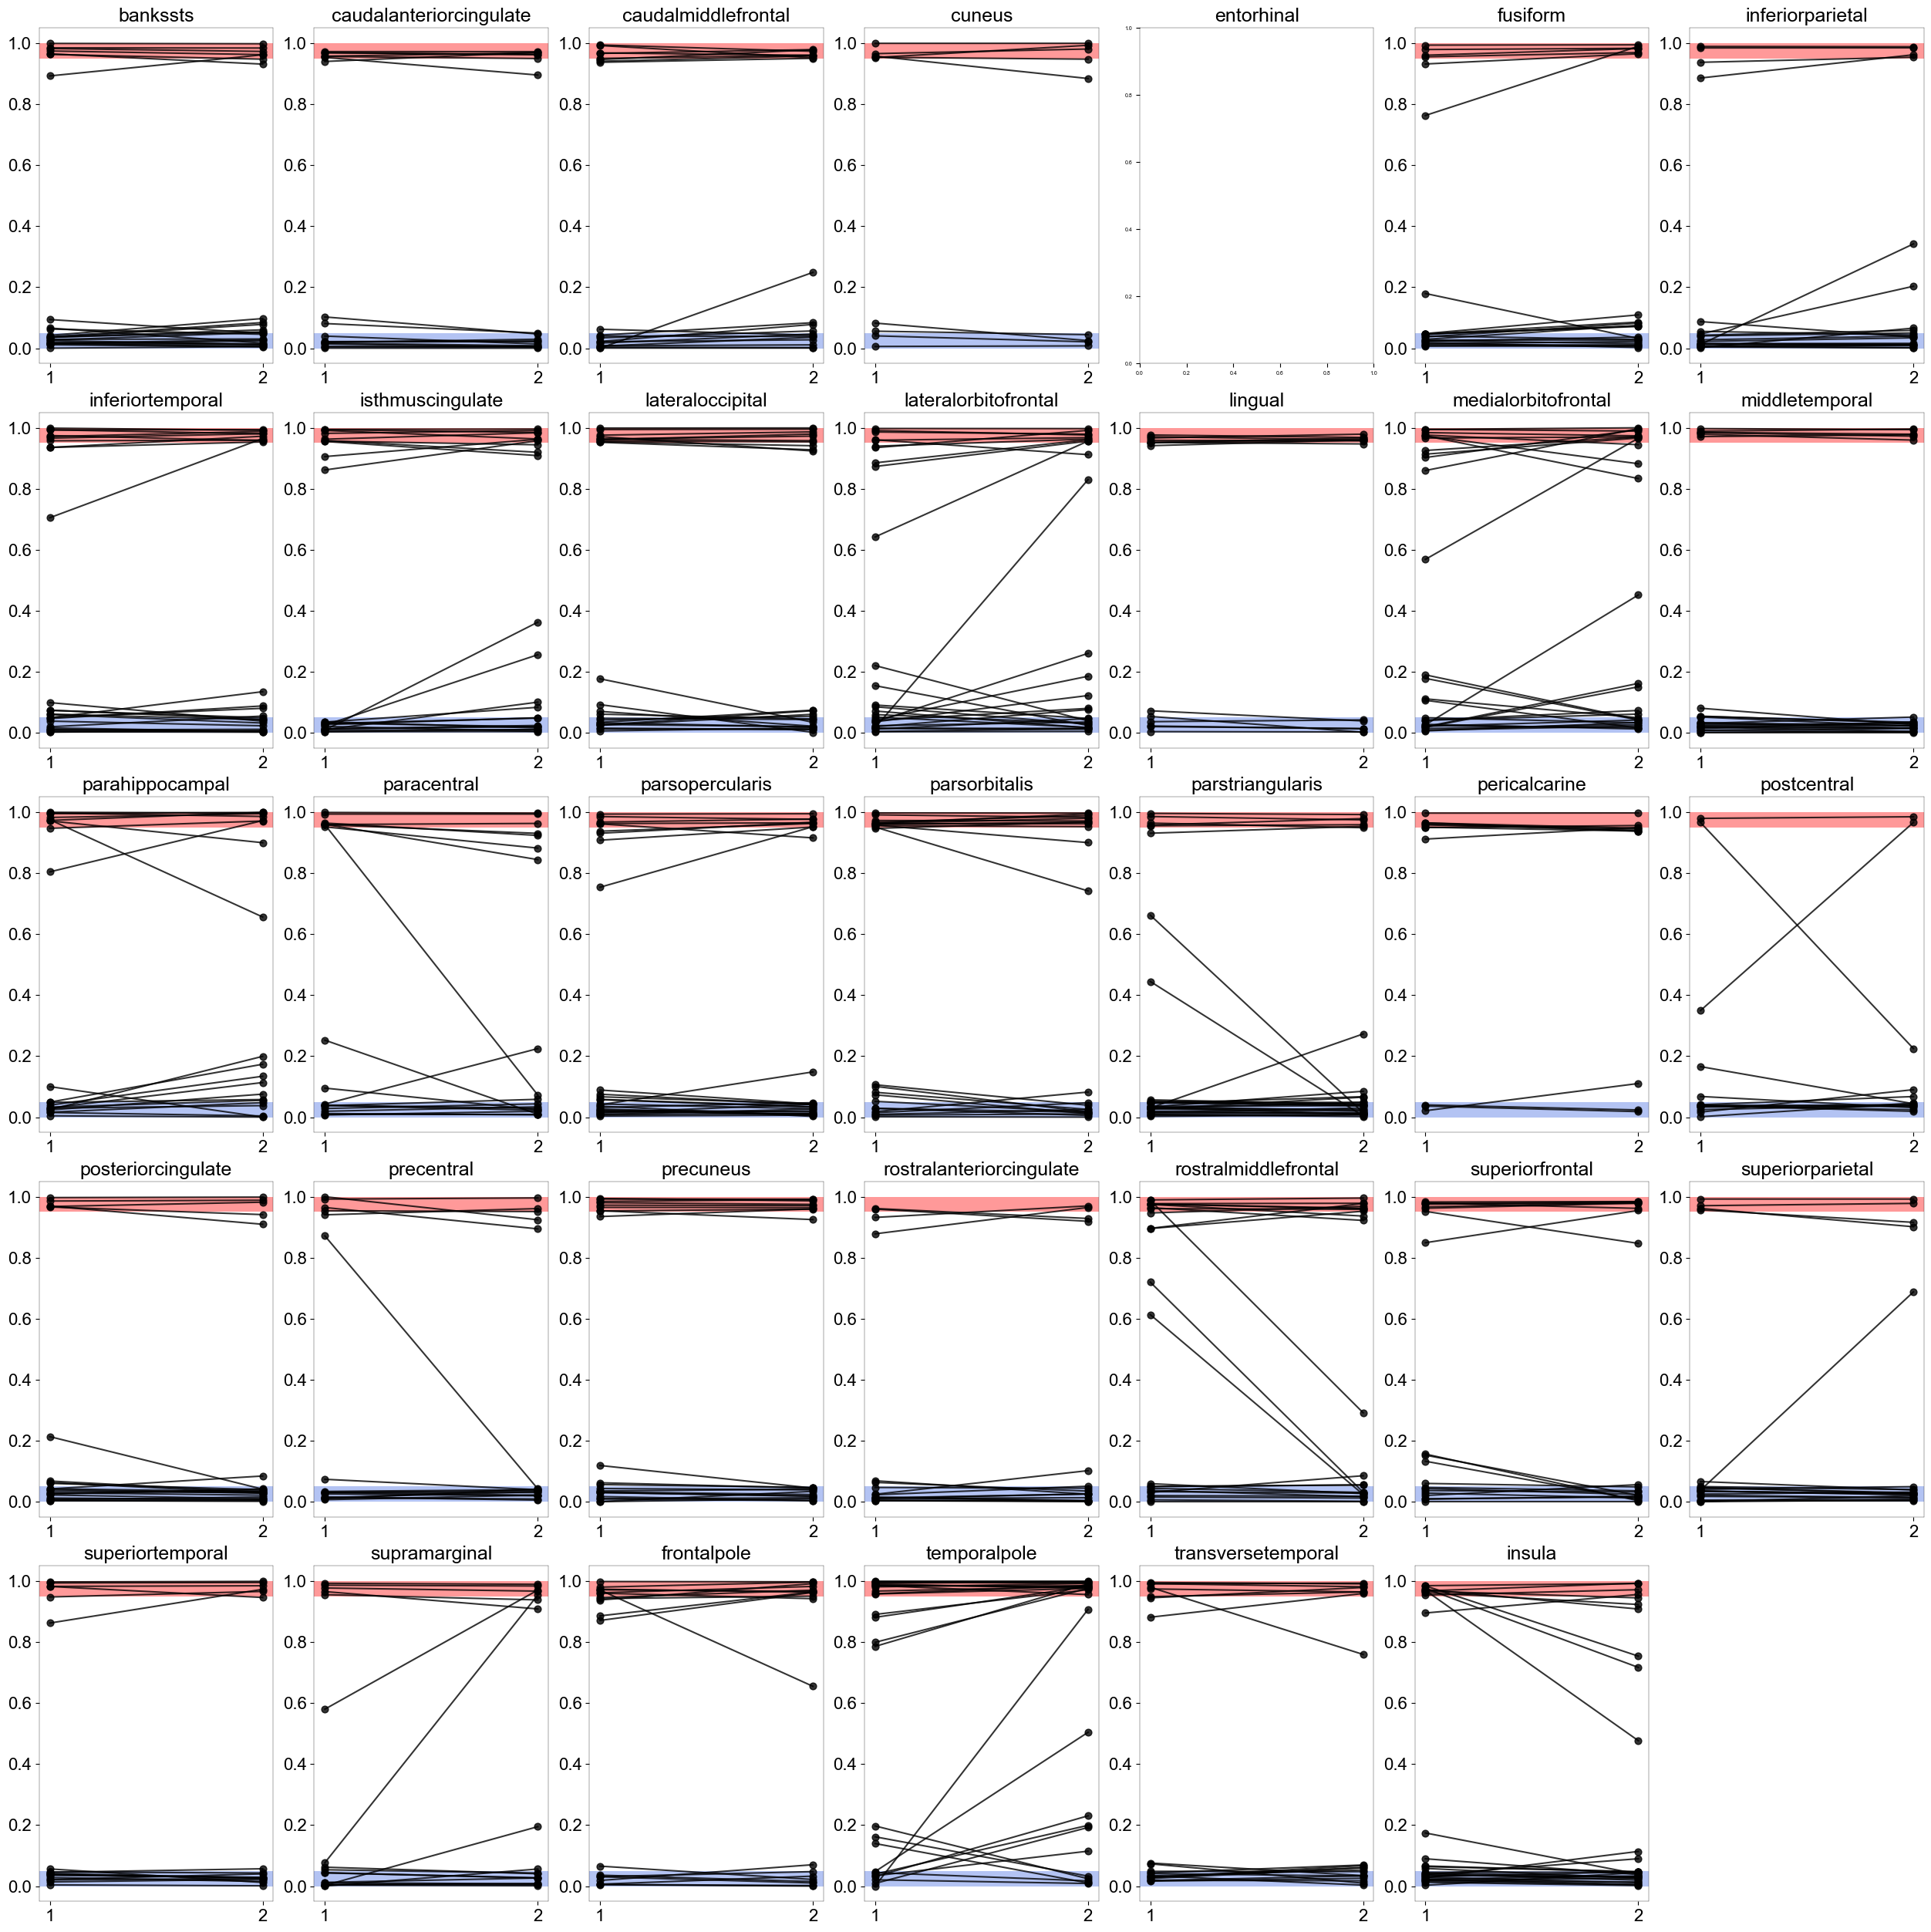

In [23]:
plot_longitudinal_data_subplots(abcd_sa_pt, rois_cortical_centiles, 'SA', out_dir, filter_extranormal=True, dataset='ABCD')

## Adult development - BLS

In [24]:
# add timepoint column
bls_26_sa['timepoint'] = 1
bls_38_sa['timepoint'] = 2

# select only preterm participants with longitudinal data
bls_26_sa_pt = bls_26_sa[bls_26_sa['dx'] == 'preterm']
bls_38_sa_pt = bls_38_sa[bls_38_sa['dx'] == 'preterm']
common_pt_participants = bls_26_sa_pt.merge(bls_38_sa_pt, on='participant', how='inner').index.to_list()
print("Common preterm participants BLS-26 and BLS-38:", len(common_pt_participants))

# filter for common participants
bls_26_sa_common = bls_26_sa.loc[common_pt_participants]
bls_38_sa_common = bls_38_sa.loc[common_pt_participants]

# concat dfs
bls_sa_pt = pd.concat([bls_26_sa_common, bls_38_sa_common], axis=0)
bls_sa_pt.sort_values(by='participant', inplace=True)
bls_sa_pt.reset_index(inplace=True)

Common preterm participants BLS-26 and BLS-38: 46


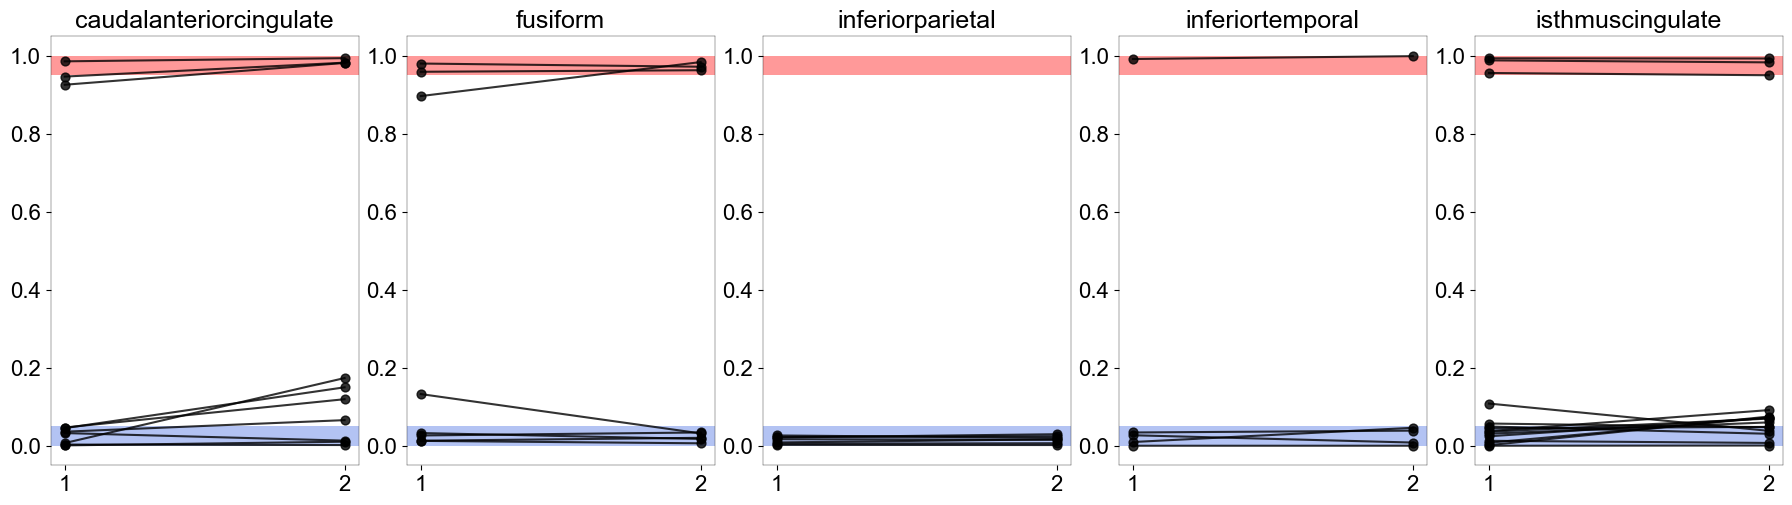

In [25]:
# show a reduced amount of ROIs in the main part
rois_main = ['centile_SA_caudalanteriorcingulate', 'centile_SA_fusiform', 'centile_SA_inferiorparietal', 
                'centile_SA_inferiortemporal', 'centile_SA_isthmuscingulate']
plot_longitudinal_data_subplots(bls_sa_pt, rois_main, 'SA', out_dir, filter_extranormal=True, num_plots=len(rois_main))

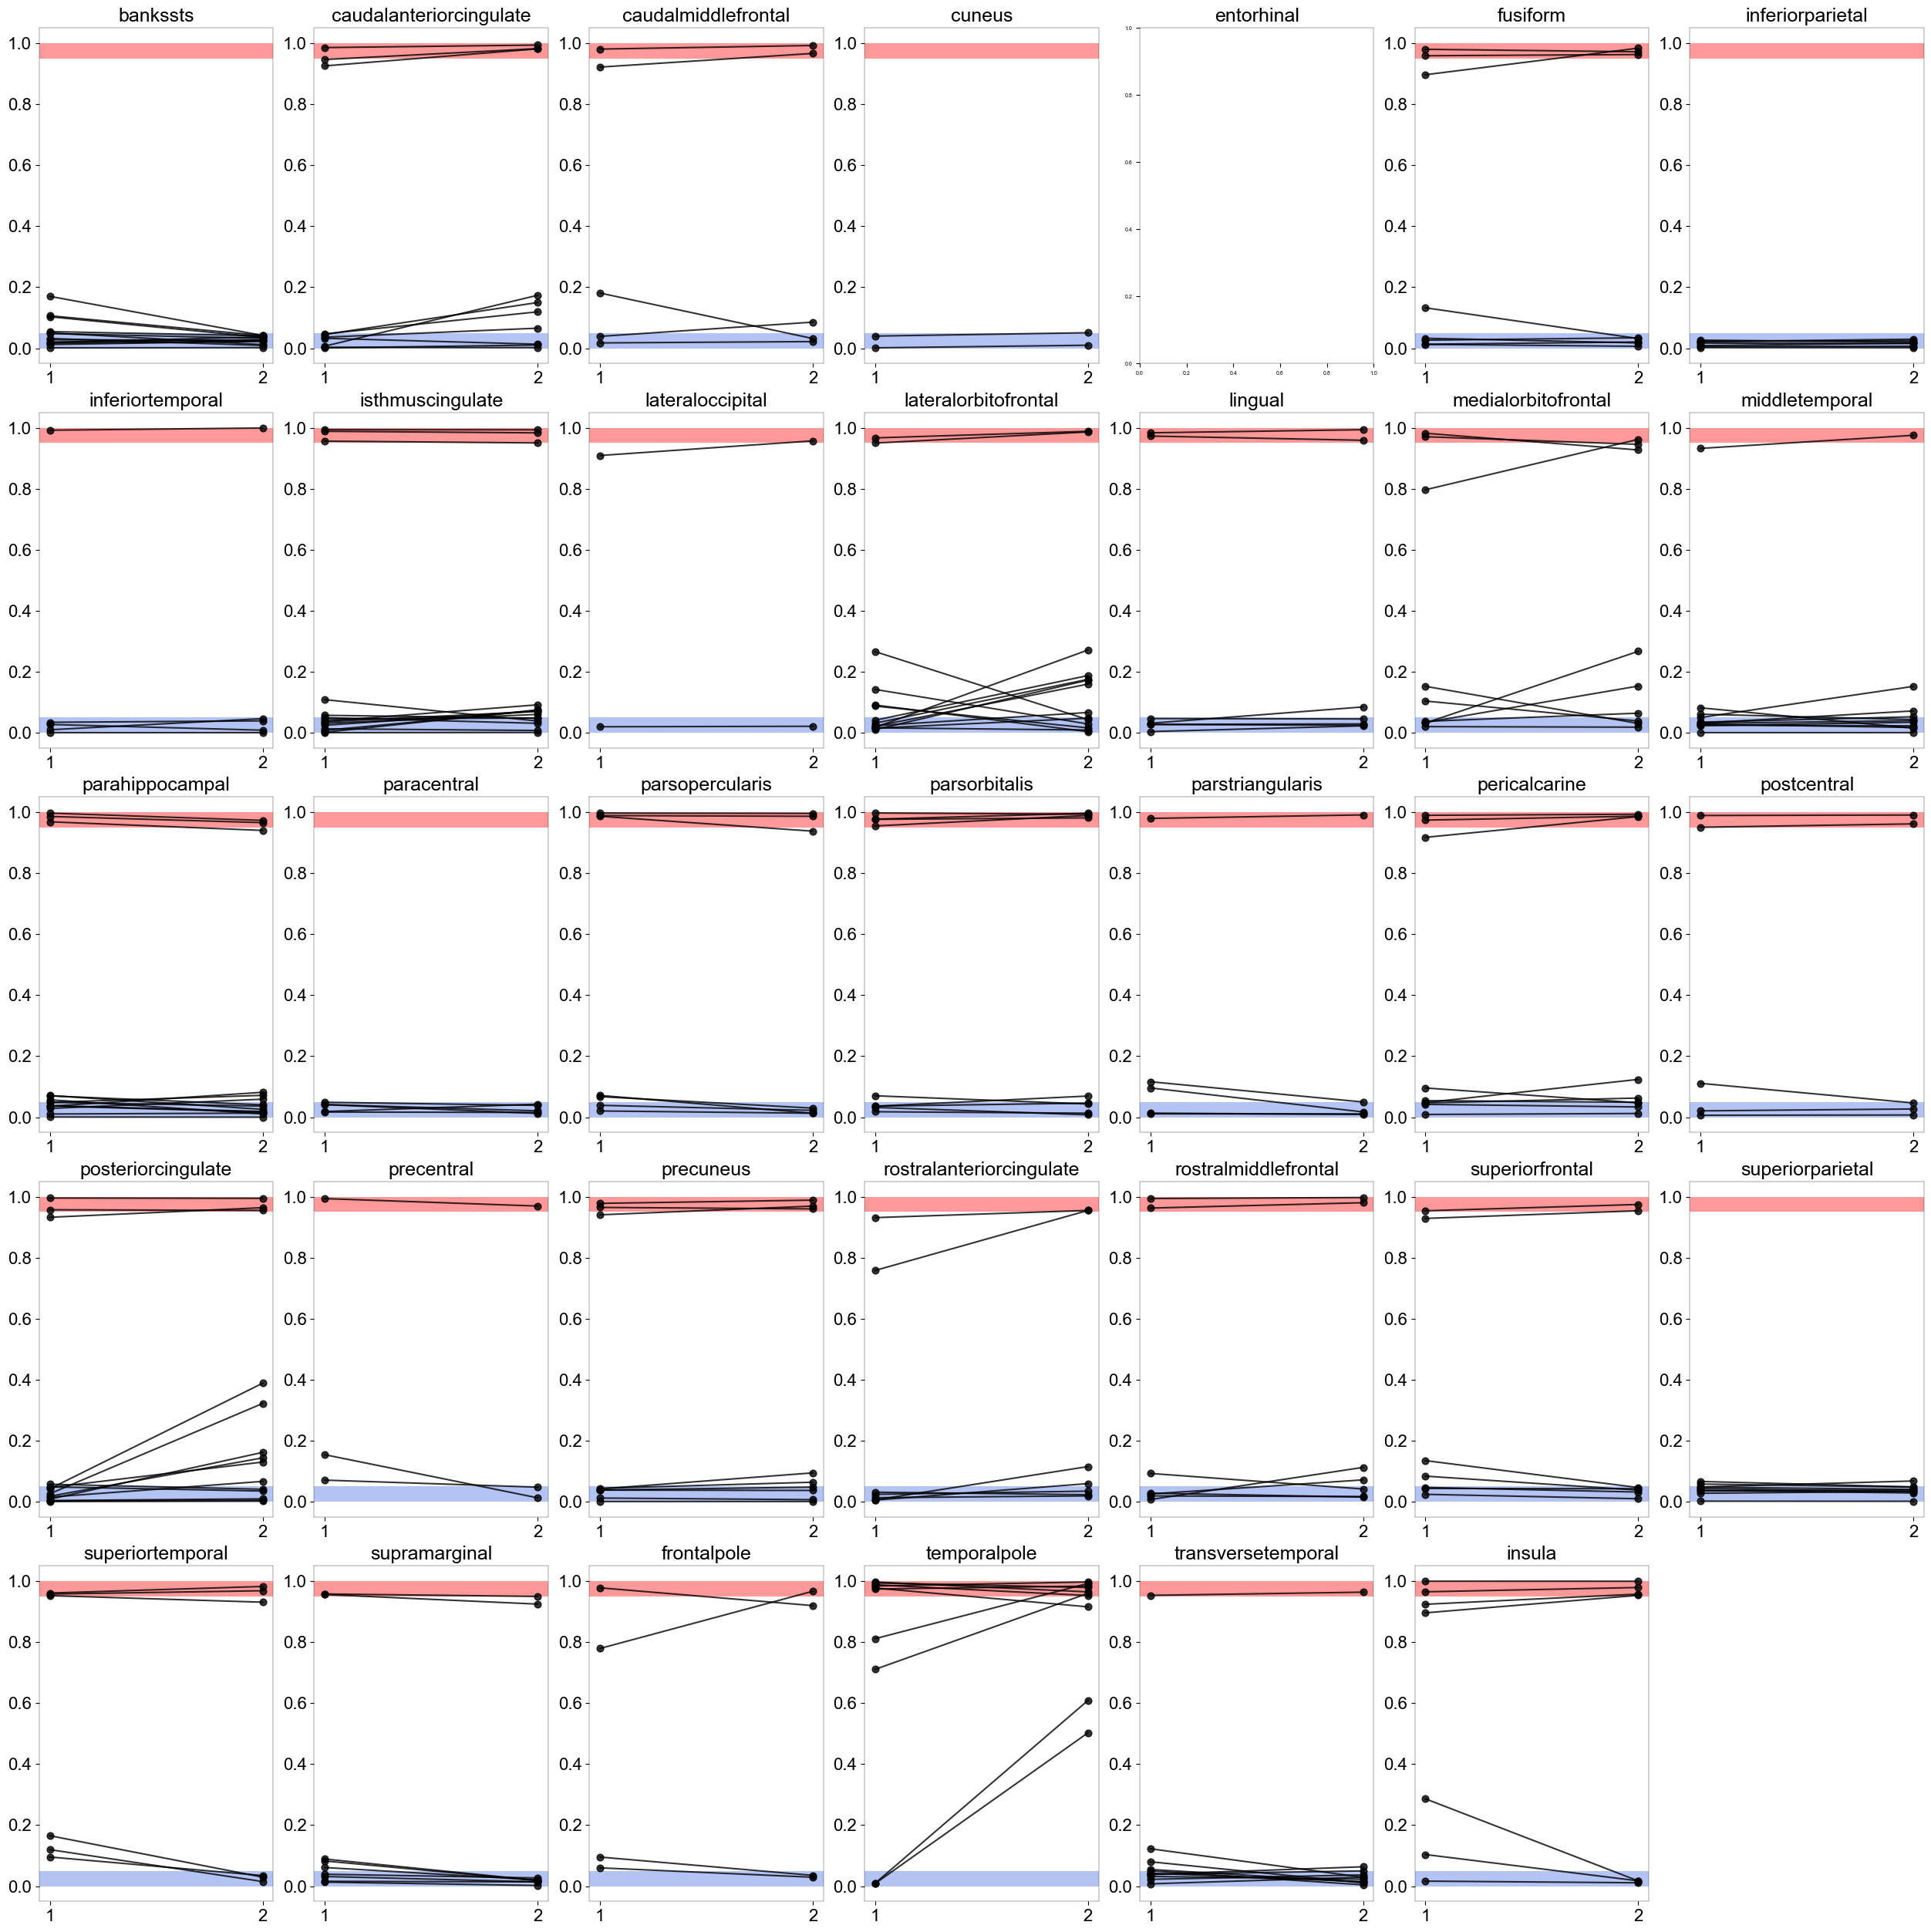

In [26]:
# show all ROIs in supplement
plot_longitudinal_data_subplots(bls_sa_pt, rois_cortical_centiles, 'SA', out_dir, filter_extranormal=True, dataset='BLS')